# Исходный Датасет

In [2]:
import pandas as pd
import numpy as np
from faker import Faker

In [4]:
fake = Faker()
num_records = 30_000_000
num_unique_values = 100


mean = 50
std_dev = 100

# Генерация уникальных значений для string колонки
unique_strings = [fake.word() for _ in range(num_unique_strings)]
unique_strings_with_digits = [f"{s}{fake.random_int(min=0, max=99)}" for s in unique_strings]

# Создание списков для каждой категории
string_with_digits = np.random.choice(unique_strings_with_digits, int(num_records * 0.7))
string_without_digits = np.random.choice(unique_strings, int(num_records * 0.2))
null_strings = [None] * int(num_records * 0.1)

# Объединение всех списков и перемешивание
all_strings = np.concatenate([string_with_digits, string_without_digits, null_strings])
np.random.shuffle(all_strings)
datetime_data = pd.date_range(start='03/01/2020', end = '4/06/2024', periods=num_records)

# Генерация значений с нормальным распределением
numeric_data = np.random.normal(loc=mean, scale=std_dev, size=num_records)

# Округление значений и приведение к заданному числу уникальных значений
# Сначала нормируем данные, чтобы они лежали в интервале от 0 до num_unique_values-1
numeric_data = np.round((numeric_data - np.min(numeric_data)) / (np.max(numeric_data) - np.min(numeric_data)) * (num_unique_values - 1))

# Приведение к целочисленному типу
numeric_data = numeric_data.astype(int)


In [5]:
# Создание DataFrame
df = pd.DataFrame({
    'numeric': numeric_data,
    'datetime': datetime_data,
    'string': all_strings
})

In [6]:
# Добавление дублей (10% записей)
duplicates = df.sample(frac=0.1, replace=True)
df = pd.concat([df, duplicates])

In [7]:
# Перемешивание записей
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
# Сохранение в CSV
df.to_csv('/Users/jandos/Desktop/large_dataset_3.csv', index=False)

In [9]:
df

,numeric,datetime,string
0,37,2021-12-15 23:50:26.298220872,two21
1,36,2023-12-09 05:49:41.059899360,quality53
2,65,2023-09-16 00:22:17.112044560,source32
3,64,2023-07-27 03:02:35.989805200,politics83
4,53,2023-02-18 00:35:33.391751104,recent29
...,...,...,...
32999995,54,2022-04-14 15:09:17.990298600,class69
32999996,58,2020-09-12 09:56:00.572392018,pressure
32999997,52,2021-01-03 02:57:18.351714612,fund24
32999998,72,2023-11-19 17:15:05.355990176,finish70


# Сведение о датасете:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000000 entries, 0 to 32999999
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   numeric   int64         
 1   datetime  datetime64[ns]
 2   string    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 755.3+ MB


In [11]:
df.describe()

,numeric,datetime
count,3.300000e+07,33000000
mean,5.042660e+01,2022-03-19 11:58:31.085315328
min,0.000000e+00,2020-03-01 00:00:00
25%,4.400000e+01,2021-03-10 06:21:03.228521984
50%,5.000000e+01,2022-03-19 11:30:02.162820096
75%,5.700000e+01,2023-03-28 17:54:19.402548736
max,9.900000e+01,2024-04-06 00:00:00
std,9.155387e+00,NaN


In [12]:
len(df['string'].unique())          #len(ratings['user_id'].unique())

199

In [ ]:
df[df['string']=='south']['string'].value_counts()

In [12]:
df_count_null = df.isnull().count()

In [13]:
df_count_null

numeric     33000000
datetime    33000000
string      33000000
dtype: int64

# Считывание и процессинг

In [13]:
import dask.dataframe as dd
import numpy as np
import pandas as pd

# Загрузка набора данных
df = dd.read_csv('/Users/jandos/Desktop/large_dataset_3.csv')

# Замена пустых строк на NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Удаление строк, где все элементы являются NaN
df = df.dropna(how='all')

# Удаление дубликатов
df = df.drop_duplicates()

# Определение функции для проверки наличия цифр
def has_digits(cell):
    if pd.isnull(cell):  # Проверка на NaN
        return cell
    if isinstance(cell, (int, float)):  # Проверка на типы int и float
        return cell
    if isinstance(cell, str) and any(char.isdigit() for char in cell):  # Проверка строк на наличие цифр
        return cell
    return ''  # Если цифр нет, вернуть пустую строку

# Применение функции к DataFrame с указанием метаданных
meta = df.map_partitions(lambda df: df.applymap(has_digits)).head()
df = df.map_partitions(lambda df: df.applymap(has_digits), meta=meta)

# Фильтрация по времени
df['datetime'] = dd.to_datetime(df['datetime'])
df = df[~((df['datetime'].dt.hour >= 1) & (df['datetime'].dt.hour < 3))]

# Выполнение всех операций и преобразование в pandas DataFrame
df = df.compute()


/var/folders/q8/phy_73j56dx2_bbk_qcsx23m0000gn/T/ipykernel_37452/3681476737.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meta = df.map_partitions(lambda df: df.applymap(has_digits)).head()
/var/folders/q8/phy_73j56dx2_bbk_qcsx23m0000gn/T/ipykernel_37452/3681476737.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meta = df.map_partitions(lambda df: df.applymap(has_digits)).head()
/var/folders/q8/phy_73j56dx2_bbk_qcsx23m0000gn/T/ipykernel_37452/3681476737.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.map_partitions(lambda df: df.applymap(has_digits), meta=meta)


In [14]:
df

,numeric,datetime,string
0,37,2021-12-15 23:50:26.298220872,two21
1,36,2023-12-09 05:49:41.059899360,quality53
2,65,2023-09-16 00:22:17.112044560,source32
3,64,2023-07-27 03:02:35.989805200,politics83
4,53,2023-02-18 00:35:33.391751104,recent29
...,...,...,...
1649930,50,2020-03-21 12:46:00.867452028,state52
1649931,54,2022-04-14 15:09:17.990298600,class69
1649932,58,2020-09-12 09:56:00.572392018,
1649934,72,2023-11-19 17:15:05.355990176,finish70


# Расчет метрик

In [15]:

df['hour'] = df['datetime'].dt.floor('H')
unique_string = df.groupby('hour')['string'].nunique().reset_index()
numeric_avg = df.groupby('hour')['numeric'].mean().reset_index()
numeric_avg


,hour,numeric
0,2020-03-01 00:00:00,50.529904
1,2020-03-01 03:00:00,50.093413
2,2020-03-01 04:00:00,49.947305
3,2020-03-01 05:00:00,50.443114
4,2020-03-01 06:00:00,50.451497
...,...,...
32930,2024-04-05 20:00:00,50.800000
32931,2024-04-05 21:00:00,50.435928
32932,2024-04-05 22:00:00,50.658683
32933,2024-04-05 23:00:00,50.238323


In [16]:
numeric_avg = df.groupby('hour')['numeric'].mean().reset_index()
numeric_avg

,hour,numeric
0,2020-03-01 00:00:00,50.529904
1,2020-03-01 03:00:00,50.093413
2,2020-03-01 04:00:00,49.947305
3,2020-03-01 05:00:00,50.443114
4,2020-03-01 06:00:00,50.451497
...,...,...
32930,2024-04-05 20:00:00,50.800000
32931,2024-04-05 21:00:00,50.435928
32932,2024-04-05 22:00:00,50.658683
32933,2024-04-05 23:00:00,50.238323


In [30]:
numeric_median = df.groupby('hour')['numeric'].median().reset_index()
numeric_median

,hour,numeric
0,2020-03-01 00:00:00,49.0
1,2020-03-01 03:00:00,49.0
2,2020-03-01 04:00:00,50.0
3,2020-03-01 05:00:00,48.0
4,2020-03-01 06:00:00,51.0
...,...,...
32930,2024-04-05 20:00:00,48.0
32931,2024-04-05 21:00:00,50.0
32932,2024-04-05 22:00:00,52.0
32933,2024-04-05 23:00:00,46.0


In [17]:
df

,numeric,datetime,string,hour
0,37,2021-12-15 23:50:26.298220872,two21,2021-12-15 23:00:00
1,36,2023-12-09 05:49:41.059899360,quality53,2023-12-09 05:00:00
2,65,2023-09-16 00:22:17.112044560,source32,2023-09-16 00:00:00
3,64,2023-07-27 03:02:35.989805200,politics83,2023-07-27 03:00:00
4,53,2023-02-18 00:35:33.391751104,recent29,2023-02-18 00:00:00
...,...,...,...,...
1649930,50,2020-03-21 12:46:00.867452028,state52,2020-03-21 12:00:00
1649931,54,2022-04-14 15:09:17.990298600,class69,2022-04-14 15:00:00
1649932,58,2020-09-12 09:56:00.572392018,,2020-09-12 09:00:00
1649934,72,2023-11-19 17:15:05.355990176,finish70,2023-11-19 17:00:00


# Гистограмма 

In [18]:
import matplotlib.pyplot as plt

In [19]:
len_numeric = len(df.numeric)
len_numeric

27500000

In [20]:
mean = df.numeric.mean()
mean

50.42642029090909

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        4.000000e+00, 1.000000e+00, 9.000000e+00, 1.200000e+01,
        2.300000e+01, 5.500000e+01, 7.700000e+01, 1.200000e+02,
        1.820000e+02, 2.750000e+02, 4.400000e+02, 6.600000e+02,
        1.037000e+03, 1.469000e+03, 2.208000e+03, 3.346000e+03,
        4.861000e+03, 6.910000e+03, 9.562000e+03, 1.352200e+04,
        1.847800e+04, 2.541200e+04, 3.430300e+04, 4.525700e+04,
        5.957000e+04, 7.764900e+04, 9.931600e+04, 1.258570e+05,
        1.588010e+05, 1.963310e+05, 2.387240e+05, 2.898220e+05,
        3.456480e+05, 4.097790e+05, 4.773260e+05, 5.505960e+05,
        6.252470e+05, 7.048440e+05, 7.845810e+05, 8.619610e+05,
        9.357160e+05, 1.006059e+06, 1.067254e+06, 1.116852e+06,
        1.157595e+06, 1.183007e+06, 1.197459e+06, 1.196145e+06,
        1.180225e+06, 1.150642e+06, 1.112602e+06, 1.057627e+06,
        9.955870e+05, 9.253340e+05, 8.505330e+05, 7.735470e+05,
        6.936980e+05, 6.155630e+05, 5.39

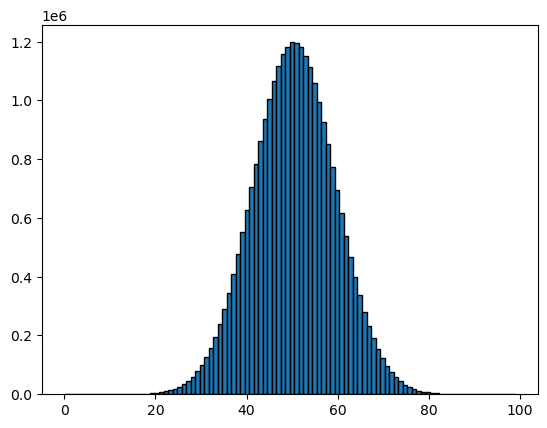

In [23]:
plt.hist(df.numeric, bins=100, edgecolor='black')

# Расчет доверительного интервала

In [27]:
import scipy.stats as stats
sample_mean = np.mean(df.numeric)
sample_std = np.std(df.numeric, ddof=1)

In [28]:
# Размер выборки
n = len(df.numeric)

In [29]:
# Стандартная ошибка среднего
sem = sample_std / np.sqrt(n)

In [30]:
# t-значение для 95% доверительного интервала и (n-1) степеней свободы
confidence_level = 0.95
alpha = 1 - confidence_level
_df = n - 1
t_critical = stats.t.ppf(1 - alpha/2, _df)

In [31]:
# Доверительный интервал
margin_of_error = t_critical * sem
ci_lower = sample_mean - margin_of_error
ci_upper = sample_mean + margin_of_error

print(f"95% доверительный интервал: ({ci_lower:.2f}, {ci_upper:.2f})")

95% доверительный интервал: (50.42, 50.43)


# Визуализация

In [32]:
df['month'] = df['datetime'].dt.to_period('M')
monthly_mean = df.groupby('month')['numeric'].mean()

In [33]:
monthly_mean

month
2020-03    50.449770
2020-04    50.440588
2020-05    50.426562
2020-06    50.410958
2020-07    50.444992
2020-08    50.414859
2020-09    50.416782
2020-10    50.430969
2020-11    50.429810
2020-12    50.412309
2021-01    50.413923
2021-02    50.432741
2021-03    50.438559
2021-04    50.429022
2021-05    50.435273
2021-06    50.427957
2021-07    50.420210
2021-08    50.451464
2021-09    50.417712
2021-10    50.403293
2021-11    50.434792
2021-12    50.432187
2022-01    50.428293
2022-02    50.448353
2022-03    50.418302
2022-04    50.433208
2022-05    50.418883
2022-06    50.411481
2022-07    50.419886
2022-08    50.433640
2022-09    50.406879
2022-10    50.413594
2022-11    50.419617
2022-12    50.446458
2023-01    50.408492
2023-02    50.435564
2023-03    50.424507
2023-04    50.415446
2023-05    50.439707
2023-06    50.418412
2023-07    50.428640
2023-08    50.425513
2023-09    50.431166
2023-10    50.413757
2023-11    50.425771
2023-12    50.427755
2024-01    50.428815
2024-02

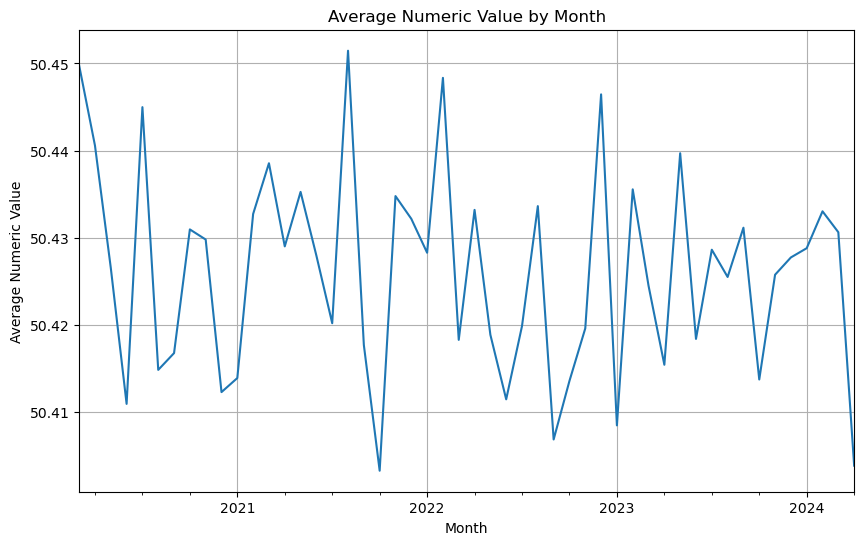

In [34]:
plt.figure(figsize=(10, 6))
monthly_mean.plot()
plt.xlabel('Month')
plt.ylabel('Average Numeric Value')
plt.title('Average Numeric Value by Month')
plt.grid(True)
plt.show()

# Деление датасета на 3 части

In [35]:
# Разделение датасета на 3 части
split_1 = int(len(df.numeric) * 0.25)
split_2 = int(len(df.numeric) * 0.5)

df_part1 = df[:split_1]
df_part2 = df[split_1:split_1 + split_2]
df_part3 = df[split_1 + split_2:]

# Проверка размеров частей
print(f'Part 1: {len(df_part1)} records')
print(f'Part 2: {len(df_part2)} records')
print(f'Part 3: {len(df_part3)} records')

Part 1: 6875000 records
Part 2: 13750000 records
Part 3: 6875000 records


In [36]:
from scipy.stats import ttest_ind

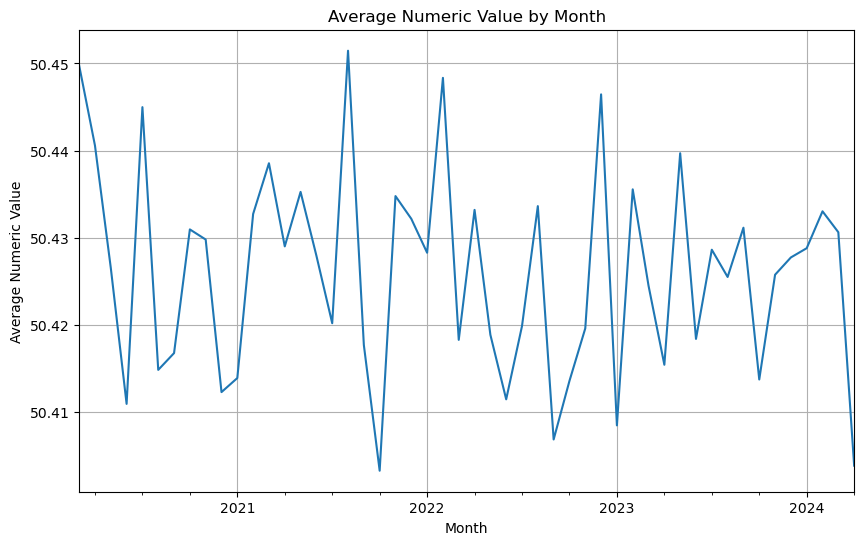

T-test between Part 1 and Part 2: t-statistic = -0.1438741741091871, p-value = 0.8855998309644361
T-test between Part 1 and Part 3: t-statistic = 0.213667553000663, p-value = 0.8308063191111321
T-test between Part 2 and Part 3: t-statistic = 0.39049640599576524, p-value = 0.6961695164274979


In [37]:
# Группировка по месяцам и вычисление среднего значения
df['month'] = df['datetime'].dt.to_period('M')
monthly_mean = df.groupby('month')['numeric'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
monthly_mean.plot()
plt.xlabel('Month')
plt.ylabel('Average Numeric Value')
plt.title('Average Numeric Value by Month')
plt.grid(True)
plt.show()

# Проверка на статистическую значимость различий
# T-test между Part 1 и Part 2
t_stat1, p_val1 = ttest_ind(df_part1['numeric'], df_part2['numeric'])
print(f'T-test between Part 1 and Part 2: t-statistic = {t_stat1}, p-value = {p_val1}')

# T-test между Part 1 и Part 3
t_stat2, p_val2 = ttest_ind(df_part1['numeric'], df_part3['numeric'])
print(f'T-test between Part 1 and Part 3: t-statistic = {t_stat2}, p-value = {p_val2}')

# T-test между Part 2 и Part 3
t_stat3, p_val3 = ttest_ind(df_part2['numeric'], df_part3['numeric'])
print(f'T-test between Part 2 and Part 3: t-statistic = {t_stat3}, p-value = {p_val3}')

In [38]:
# Функция для вычисления Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    d = (np.mean(x) - np.mean(y)) / pooled_std
    return d

# Оценка силы эффекта между Part 1 и Part 2
d1 = cohen_d(df_part1['numeric'], df_part2['numeric'])
print(f'Cohen\'s d between Part 1 and Part 2: {d1}')

# Оценка силы эффекта между Part 1 и Part 3
d2 = cohen_d(df_part1['numeric'], df_part3['numeric'])
print(f'Cohen\'s d between Part 1 and Part 3: {d2}')

# Оценка силы эффекта между Part 2 и Part 3
d3 = cohen_d(df_part2['numeric'], df_part3['numeric'])
print(f'Cohen\'s d between Part 2 and Part 3: {d3}')

Cohen's d between Part 1 and Part 2: -6.720353558156864e-05
Cohen's d between Part 1 and Part 3: 0.00011524370787677381
Cohen's d between Part 2 and Part 3: 0.00018240062385964275


In [39]:
pip install pymc3 arviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.6/872.6 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 10.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 10.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 9.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 

# Второе доп задание


Вводные
Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных.
Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Какими методами можно решать данную задачу? Предложите как минимум 2 варианта. Если у вас есть какой-то вариант решения задачи для которого требуются доп. данные - перечислите что требуется и метод решения.


Конкурент выпустил 1000 прототипов, из которых 5 успешных
P(успешные у конкурента) = 5/1000 = 0.005

Наша компания выпустила 200 прототипов, из которых 0 успешных.
P(успешные у нашего)=0/200 = 0.

In [41]:
##Определение вероятности успеха 201-го прототипа.

Если предыдущие 200 прототипов были неуспешными, то вероятность 201 экземпляра:
    P(201 успех) = 0. (Ограничения:
Этот метод не учитывает возможность изменения стратегии или улучшений, которые могли бы увеличить вероятность успеха в будущем.)

In [42]:
##Байесовский подход

Для априорного распределения вероятности успеха можно использовать бета-распределение 
Beta
(
α
,
β
)
Beta(α,β). Поскольку у нас нет успешных прототипов, начнем с 
α
=
1
α=1 и 
β
=
201
β=201 (одно успешное и 200 неуспешных).

(Поскольку мы не наблюдали успехов, апостериорное распределение будет 
Beta
(
1
,
201
)
Beta(1,201).)

Анализ данных конкурента:
Если у нас есть данные о том, что делало игры конкурента успешными, мы можем использовать машинное обучение для предсказания успеха наших игр.

Требуемые данные:

Характеристики каждого прототипа (жанр, платформа, бюджет и т.д.).
Данные о рынке и аудитории. 

То есть мы можем обучить модель по регрессионому анализу или случайному лесу (используя библиотеки sckit-learn) и определить, что же делает успешным игры этого конкурента